# Regression takehome assignment

In [1]:
import numpy as np
import pickle
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib widget

## Preprocessing

Load training data and see the structure of the data. Check if there's missing data.

In [2]:
df_train = pd.read_csv('RegressionExample_train.csv')

In [3]:
df_train.head(5)

,y,x1,x2
0,2.580808,-1.655870,1.243678
1,2.085190,0.882247,1.299029
2,0.016945,-0.341965,3.650802
3,0.689864,-1.469734,1.370667
4,-0.825232,0.323903,0.534371


In [4]:
target_col = ['y']
predictor_col = ['x1', 'x2']
X_df, y_df = df_train[predictor_col], df_train[target_col]

## Basic data exploration and visualization

### First look

It seems there's no huge outliers in the target variables or predictor variables, so feature scaling shouldn't cause any issues.

In [5]:
df_train.describe()

,y,x1,x2
count,4000.000000,4000.000000,4000.000000
mean,1.064603,-0.009546,1.501741
std,1.960072,1.009531,1.074500
min,-8.311614,-3.503908,0.016869
25%,-0.176006,-0.675378,0.734204
50%,1.028124,-0.011988,1.248602
75%,2.213104,0.667306,2.006820
max,8.595653,3.274246,8.126406


There's also no missing data, so imputation is also not necessary.

In [6]:
# Is there any missing data?
df_train.isna().any(axis=None)

False

### Visualization
To visualize the data, we create an interactive (in Jupyter) 3d scatterplot. Each point is colored according to its $x_1$ value to make the structure a bit more visible.

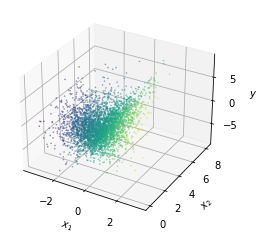

In [7]:
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_df['x1'], X_df['x2'], y_df, alpha=0.5, s=0.4, c=X_df['x1'])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')
plt.show()
plt.ioff()

The points don't all seem to belong to the same plane, so ordinary least squares won't work some additional work (e.g., transforming the features). Since they seem to all be near a 2-dimensional saddle-shaped surface, one possibility is to introduce polynomial features (e.g., $x_1^2, x_1x_2, x_2^2$) and apply OLS regression.

## Model training

### Initial model
We'll try a few methods for regression: ordinary least squares, nonlinear support vector regression, and k-nearest-neighbor regression. To easily perform cross-validation using different algorithms all at once, we'll create a dummy estimator class to plug into a pipeline.

In [8]:
X = X_df.values
y = y_df.values.ravel()

In [9]:
class DummyRegressor(BaseEstimator):
    def fit(self): pass
    def score(self): pass

dummy_regressor = DummyRegressor()
scaler = StandardScaler()
poly_feature = PolynomialFeatures()

pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("poly_feature", poly_feature),
    ("reg", dummy_regressor),
])

knn = KNeighborsRegressor()
svr = SVR()
ols = LinearRegression()

knn_grid = {
    "reg": [knn],
    "reg__n_neighbors": range(1,60),
    "reg__weights": ['uniform', 'distance'],
    "poly_feature__degree": [1],
    "poly_feature__include_bias": [False],
}

nonlinear_svr_grid = {
    "reg": [svr],
    "reg__kernel": ['poly', 'rbf'],
    "reg__C": [0.001, 0.01, 1, 10, 100],
    "reg__epsilon": [0.001, 0.01, 0.1],
    "poly_feature__degree": [1],
    "poly_feature__include_bias": [False],
}

ols_grid = {
    "reg": [ols],
    "poly_feature__degree": [2],
    "poly_feature__include_bias": [False],
}

grid = [knn_grid, nonlinear_svr_grid, ols_grid]

In [10]:
search = GridSearchCV(pipe, grid, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)

In [11]:
# This might take a while
search.fit(X, y)

Fitting 5 folds for each of 149 candidates, totalling 745 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly_feature', PolynomialFeatures()),
                                       ('reg', DummyRegressor())]),
             n_jobs=-1,
             param_grid=[{'poly_feature__degree': [1],
                          'poly_feature__include_bias': [False],
                          'reg': [KNeighborsRegressor()],
                          'reg__n_neighbors': range(1, 60),
                          'reg__weights': ['uniform', 'distance']},
                         {'poly_feature__degree': [1],
                          'poly_feature__include_bias': [False],
                          'reg': [SVR(C=10)],
                          'reg__C': [0.001, 0.01, 1, 10, 100],
                          'reg__epsilon': [0.001, 0.01, 0.1],
                          'reg__kernel': ['poly', 'rbf']},
                         {'poly_feature__degree': [2],
                          'poly_feature__include_

The results of the CV search are:

In [12]:
search.best_params_

{'poly_feature__degree': 1,
 'poly_feature__include_bias': False,
 'reg': SVR(C=10),
 'reg__C': 10,
 'reg__epsilon': 0.1,
 'reg__kernel': 'rbf'}

In [13]:
search.best_score_

-1.0226985183230863

The lowest obtained RMSE is $\approx 1.023$.

### Hyperparameter fine-tuning
We'll attempt to decrease the RMSE a little more by tuning the hyperparameters for SVR with radial basis functions--the algorithm with the best RMSE above. 

In [14]:
nonlinear_svr_grid_2 = {
    "reg": [svr],
    "reg__kernel": ['rbf'],
    "reg__C": np.linspace(8, 20, 10),
    "reg__epsilon": np.linspace(0.05, 2, 10),
    "poly_feature__degree": [1],
    "poly_feature__include_bias": [False],
}

search = GridSearchCV(pipe, nonlinear_svr_grid_2, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)

In [15]:
search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly_feature', PolynomialFeatures()),
                                       ('reg', DummyRegressor())]),
             n_jobs=-1,
             param_grid={'poly_feature__degree': [1],
                         'poly_feature__include_bias': [False],
                         'reg': [SVR(C=16.0, epsilon=0.48333333333333334)],
                         'reg__C': array([ 8.        ,  9.33333333, 10.66666667, 12.        , 13.33333333,
       14.66666667, 16.        , 17.33333333, 18.66666667, 20.        ]),
                         'reg__epsilon': array([0.05      , 0.26666667, 0.48333333, 0.7       , 0.91666667,
       1.13333333, 1.35      , 1.56666667, 1.78333333, 2.        ]),
                         'reg__kernel': ['rbf']},
             scoring='neg_root_mean_squared_error', verbose=1)

Fine-runing results in a modest improvement with hyperparameters chosen somewhere inside the search grid, so this is likely the best we can do. We'll save the model so we don't have to re-train it over and over.

In [16]:
search.best_score_

-1.020662310853418

In [17]:
search.best_params_

{'poly_feature__degree': 1,
 'poly_feature__include_bias': False,
 'reg': SVR(C=16.0, epsilon=0.48333333333333334),
 'reg__C': 16.0,
 'reg__epsilon': 0.48333333333333334,
 'reg__kernel': 'rbf'}

In [18]:
best_estimator = search.best_estimator_

### Sanity checks

#### Same surface
We visually check that the predicted values form a surface similar to the one given by the training data.

In [19]:
y_predict = best_estimator.predict(X)

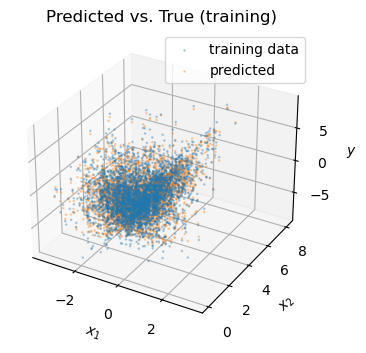

In [20]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X[:,0], X[:,1], y, alpha=0.3, s=0.75, c='C0', label='training data')
ax.scatter(X[:,0], X[:,1], y_predict, alpha=0.3, s=0.75, c='C1', label='predicted')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')
plt.legend()
plt.title("Predicted vs. True (training)")
plt.show()

#### Residuals
We also check the residuals aren't unusually large for some prediction values or for some values of $(x_1, x_2)$.

In [21]:
residuals = y - y_predict
pd.DataFrame(residuals).describe()

,0
count,4000.000000
mean,0.012750
std,1.005017
min,-3.906819
25%,-0.656476
50%,-0.017940
75%,0.694107
max,3.390631


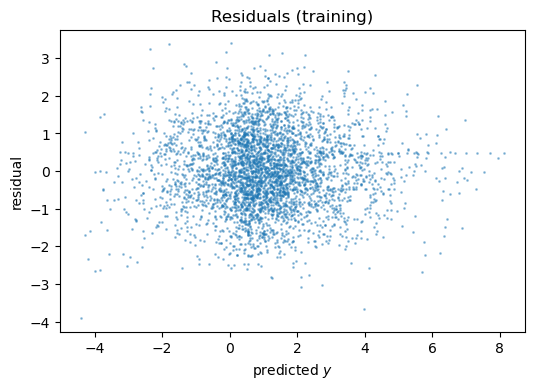

In [22]:
plt.figure(dpi=100)
plt.scatter(y_predict, residuals, s=1, alpha=0.4)
plt.ylabel("residual")
plt.xlabel("predicted $y$")
plt.title("Residuals (training)")
plt.show()

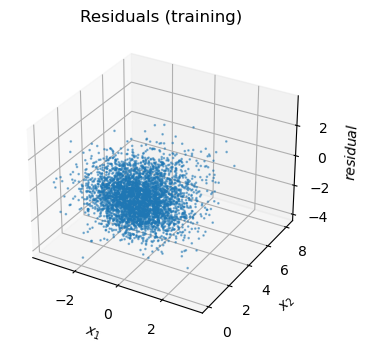

In [23]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X[:,0], X[:,1], residuals, alpha=0.5, s=0.75, c='C0')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$residual$')
plt.title("Residuals (training)")
plt.show()

There is no obvious systematic problems, so we'll save the model and test it against the testing set. 

### Save model
Save the model so we don't have to retrain it again.

In [24]:
pickle_filename = "best_regression_model.p"

with open(pickle_filename, "wb") as f:
    pickle.dump(search.best_estimator_, f)

## Testing

Let's check the RMSE on the testing data set is not outrageously high.

We load the testing data and saved model:

In [25]:
X_test = pd.read_csv("RegressionExample_test_input.csv").values
y_test = pd.read_csv("RegressionExample_test_output.csv").values.ravel()

In [26]:
with open(pickle_filename, "rb") as f:
    regressor = pickle.load(f)

...and compute the RMSE:

In [27]:
y_predict_test = regressor.predict(X_test)

In [28]:
mean_squared_error(y_test, y_predict_test, squared=False)

1.05673883964476

The testing RMSE is similar to the training RMSE, so it seems we have a good estimator.

Plotting the predicted values vs. the true values shows both are roughly on the same surface:

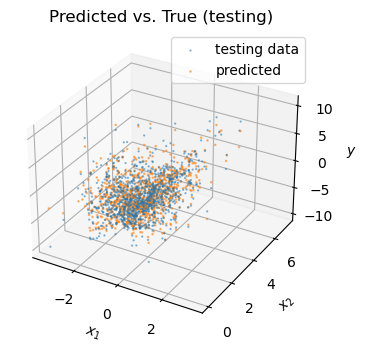

In [29]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_test[:,0], X_test[:,1], y_test, alpha=0.5, s=0.4, c='C0', label='testing data')
ax.scatter(X_test[:,0], X_test[:,1], y_predict_test, alpha=0.5, s=0.75, c='C1', label='predicted')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')
plt.legend()
plt.title("Predicted vs. True (testing)")
plt.show()